# Unsupervised Learning
[![Run in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bobmh43/handson_ml/blob/master/notebooks/unsupervised_learning.ipynb)

# End-of-chapter Exercises

Takeways:
- simple algorithms such as KMeans and Linear Regression usually have limited uses (their assumptions are too strong) (eg. KMeans looks for clusters that are spherical, of similar size and of similar density.) However, they are fast and scalable and can be used as a first attempt at the task.

- semi-supervised learning methods include clustering + label propagation + supervised or active learning using supervised

## Clustering and more specifically, K-Means:
*1. How would you define clustering? Name a few clustering algorithms.*

Clustering is the unsupervised machine learning task of grouping similar instances together. The exact definition of a cluster various between algorithms, from the instances close to a centroid (K-Means), to a group of instances of high density (DBSCAN), to a Gaussian distribution (GMM).
[Distance vs Density.]

Examples of clustering algorithms include K-Means, DBSCAN, Agglomerative clustering, BIRCH, Mean-shift, Affinity propagation and spectral clustering.

*2. What are some of the main applications of clustering algorithms?*

They can be combined with a classifier to perform semi-supervised learning. Other applications of clustering image segmentation by colors, recommender systems and data analysis of the clusters. The trained clustering model can provide an instance's affinity with each of clusters, and this leads to applications such as dimensionality reduction and anomaly detection.

*3. What are two ways to select the optimal number of clusters for k-means?*

One way would be to train k-means for various values of k and plot the inertias. The elbow or inflection point on the graph would correspond to the optimal k. (Note that the graph is monotonically decreasing.)

Another way would be train k-means for various values of k and plot the silhouette score of each cluster model. The model with the optimal number of clusters has one of the highest silhouette score. We use the silhouette diagrams to perform a more thorough analysis (looking for clusters of similar sizes).

*4. What is label propagation? Why would you implement it and how?*

Labeling training instances is expensive. Label propagation reduces this cost by only requiring a small number of labeled instances and spreading their labels to training instances similar to them. This adapts a supervised learning algorithm to a semi-supervised task.

Implementation: We first run a clustering algorithm on the unlabeled training data. Next, we identify representative instances from these clusters and request labeling from experts. We then propagate these labels to all instances of these clusters.

*5. What are two clustering algorithms that can scale to large datasets? That are density-based?*
K-Means and BIRCH can scale to large datasets. DBSCAN and Mean-shift are density-based.

*6. When would active learning be useful? How would you implement it?*
Active learning is another method (other than label propagation) to perform semi-supervised learning.

One approach is uncertainty sampling. We first train the classifier on the small number of labeled instances and use it to predict the class probabiltiies  of all the unlabeled instances. Those instances that the model is most unsure of are sent to the expert for relabeling. The process is repeated until the model improvement is minimal.

Other approaches include labeling the instances that would result in the largest model change or the largest drop in the model's validation error or the instances that different models disagree on.

## Anomaly detection
*7. What is the difference between anomaly detection and novelty detection?*

Both are meant to decide whether new instances are outliers. They differ in how they are trained. Anomaly detection algorithms are trained on messy data -- data that includes both inliers and outliers (unlabeled, unsupervised). Novelty detection algorithms are trained on clean data -- only inliers.

## Gaussian Mixtures: density estimation

*8. What is a Gaussian Mixture? What tasks can it be used for?*

A Gaussian Mixture Model is a generative density estimation model. It assumes that the training data was generated from a mixture of gaussian distributions and seeks to learn the most likely parameters of those distributions. Aside from density estimation, it can be used for clustering and anomaly detection.

*9. What are two techniques to find the optimal number of clusters for a Gaussian Mixture Model?*

The first approach would be to use a theoretical information criterion, either Bayesian (BIC) or Akeike (AIC). We train several GMMs with different values of k and identify the model with the lowest BIC or AIC. A model has low information criterion if it has a small number of parameters and a high maximum value of its likelihood function.

The second approach would be to used the Bayesian Gaussian Mixture Model and provide it with a `n_components` that is beyond the optimal value. The algorithm will eliminate the redundant components.

# Exercise: Olivetti faces

- Olivetti faces dataset: 40 people x 10 pictures each. 400 instances with 40 label values. This dataset has a small number of instances per class and is meant for unsupervised or semi-supervised learning.

Takeaway: Unsupervised tasks are related:
- Density estimation ==> clustering (`predict()`)
- Clustering ==> Anomaly detection (affinity metric is under a threshold. Ie, `transform().min() > threshold` or `predict_proba().max() < threshold`. The threshold is determined by a `np.percentile()` of the affinity metrics of the training instances.)
- Clustering ==> dimensionality reduction (`transform()` or `predict_proba()`)
- Dimensionality reduction ==> anomaly reduction (reconstruction error)

```
# kmeans clustering
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
kmeans.labels_ # labels of the training instances
kmeans.predict(X_new) # clustering new instances

# kmeans for dimensionality reduction
kmeans.transform(X_new) # afiinities / distances to centroids

# kmeans for outlier detection
threshold = np.percentile(kmeans.transform(X).min(axis=1), 98)
is_outlier = kmeans.transform(X_new).min(axis=1) > threshold


# gaussian mixture
gm = GaussianMixture(n_components=10)
gm.fit(X)

# gm generating new instances
X_new = gm.sample(10)

# gm performing clustering
gm.predict(X); gm.predict(X_new)

# gm performing dimensionality reduction
gm.predict_proba(X_new)

# gm performing outlier detection
threshold = np.percentile(gm.predict_proba(X).max(axis=1), 2)
is_outlier = gm.predict_proba(X_new).max(axis=1) < threshold


# dbscan
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)

# dbscan for clustering: various ways to train the classifier for clustering. DBSCAN serves to add training labels to the data.
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_]);
not_outliers = dbscan.labels_ != -1
knn.fit(X[not_outliers], dbscan.labels_[not_outliers])
knn.fit(X, dbscan.labels_)
knn.predict(X_new)

# dbscan for anomaly detection (if the KNN was not trained on outliers as well)
core_dist, core_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][core_idx]
y_pred[core_dist > 0.2] = -1
y_pred.ravel()



# pca for dimensionality reduction
pca = PCA(n_components=0.95)
pca.fit(X)
pca.transform(X); pca.transform(X_new)

# pca for outlier detection
train_recon_errors = np.mean((X - pca.inverse_transform(pca.transform(X))) ** 2, axis=1)
threshold = np.percentile(train_recon_errors, 98)
X_new_reconstructed = pca.inverse_transform(pca.transform(X_new))
recon_errors = np.mean((X_new - X_new_reconstructed) ** 2, axis=1)
is_outlier = recon_errors > threshold
```

In [ ]:
# setup imports
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline, make_union, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# load dataset. It has already been MinMaxScaled.
X, y = sklearn.datasets.fetch_olivetti_faces(return_X_y=True)
assert X.shape == (400, 4096)
assert y.shape == (400,)

In [ ]:
# split into train, val, test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=40, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=80, random_state=42, stratify=y_train_val)

assert X_train.shape == (280, 4096)
assert X_val.shape == (80, 4096)
assert X_test.shape == (40, 4096)

## Subexercise 1: clustering Olivetti faces

In [ ]:
# perform PCA for speedup. We get a 20-fold reduction in dimension for a 1% loss in variance.
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)

In [ ]:
# perform K-means clustering, with different values of k
kvalues = range(5, 150, 5)
kmeans_list = [KMeans(n_clusters=k, random_state=43).fit(X_train_pca)
               for k in kvalues] # k-means++ run once

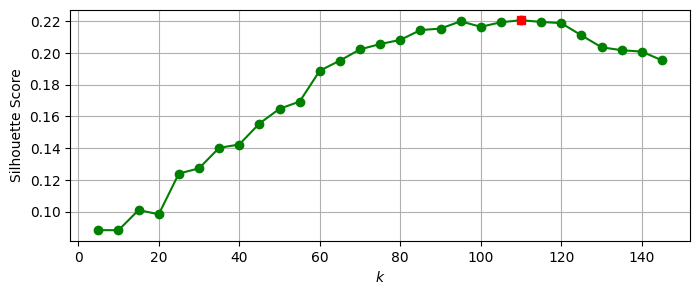

In [ ]:
# choosing the optimal k by silhouette
sil_score_list = [silhouette_score(X_train_pca, kmeans.labels_)
                  for kmeans in  kmeans_list]
best_idx = np.argmax(sil_score_list)
best_k = kvalues[best_idx]
best_score = sil_score_list[best_idx]

plt.figure(figsize=(8, 3))
plt.plot(kvalues, sil_score_list, "go-")
plt.plot(best_k, best_score, "rs")
plt.xlabel("$k$")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

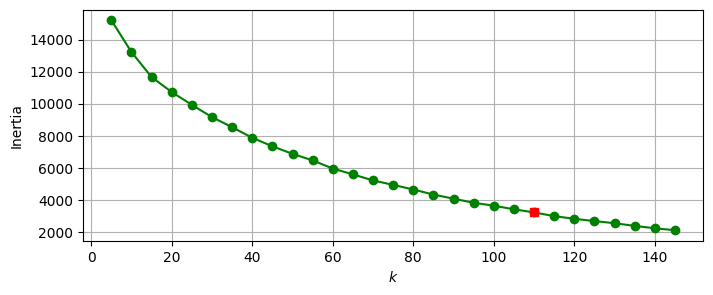

In [ ]:
# checking the values of the inertias
inertia_list = [kmeans.inertia_ for kmeans in kmeans_list]
best_inertia = inertia_list[best_idx]

plt.figure(figsize=(8, 3))
plt.plot(kvalues, inertia_list, "go-")
plt.plot(best_k, best_inertia, "rs")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.grid()
plt.show()

In [ ]:
best_model = kmeans_list[best_idx]

In [ ]:
# visualize some of the clusters
def plot_faces(X, y, subfig, ncols=5):
    X = X.reshape((-1, 64, 64))
    nrows = (X.shape[0] - 1) // ncols + 1
    for idx, (img, y) in enumerate(zip(X, y)):
        ax = subfig.add_subplot(nrows, ncols, idx + 1)
        ax.imshow(img, cmap="gray")
        ax.set_axis_off()
        ax.set_title(y)

In [ ]:
SIZE = 5
fig = plt.figure(figsize=(9, 15))
subfigs = fig.subfigures(SIZE, 1)
random_indices = np.random.randint(0, best_k, size=SIZE)
for idx, subfig in zip(random_indices, subfigs):
    subfig.suptitle(f"Cluster {idx + 1}")
    cluster_indices = best_model.labels_ == idx
    plot_faces(X_train[cluster_indices], y_train[cluster_indices], subfig)
plt.show()

## Subexercise 2: Compare classification performance with and without cluster preprocessing

Essentially: using clustering for dimensionality reduction

Conclusion: The cluster affinities do not improve classification performance. This means that the cluster affinities do not contain all of the relevant information for this classification task.

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=150)
param_distrib = {"n_estimators": range(100, 200, 10), "max_depth": [5, 10, 50, 100], "max_leaf_nodes": [40, 80, 120, 200, 400]}

scv = RandomizedSearchCV(rnd_clf, param_distrib, cv=5, n_iter=20)
scv.fit(X_train_val, y_train_val)
print("best_params_:", scv.best_params_)
print("best_score_:", scv.best_score_)

best_params_: {'n_estimators': 140, 'max_leaf_nodes': 80, 'max_depth': 100}
best_score_: 0.9444444444444444


In [ ]:
pca_rnd = Pipeline([
    ("pca", PCA()),
    ("rf", RandomForestClassifier())
])
param_distrib = {"pca__n_components": [0.95, 0.99],
                 "rf__n_estimators": range(100, 200, 10),
                 "rf__max_depth": [50, 100, 200, 400, 600],
                 "rf__max_leaf_nodes": [80, 120, 200, 400, 600]}
scv2 = RandomizedSearchCV(pca_rnd, param_distrib, n_iter=20, cv=3, random_state=43)
scv2.fit(X_train_val, y_train_val)
print("best_params_:", scv2.best_params_)
print("best_score_:", scv2.best_score_)

best_params_: {'rf__n_estimators': 170, 'rf__max_leaf_nodes': 120, 'rf__max_depth': 50, 'pca__n_components': 0.95}
best_score_: 0.9416666666666665


In [ ]:
pca_km_rnd = Pipeline([
    ("pca", PCA(0.99)),
    ("km", KMeans()),
    ("rf", RandomForestClassifier())
])
param_distrib = {"pca__n_components": [0.95, 0.99],
                 "km__n_clusters": range(10, 200, 10),
                 "rf__n_estimators": range(100, 200, 10),
                 "rf__max_depth": [10, 50, 100, 200, 400, 600],
                 "rf__max_leaf_nodes": [40, 80, 120, 200, 400, 600]
}
scv3 = RandomizedSearchCV(pca_km_rnd, param_distrib, n_iter=20, cv=3, random_state=43)
scv3.fit(X_train_val, y_train_val)
print("best_params_:", scv3.best_params_)
print("best_score_:", scv3.best_score_)

best_params_: {'rf__n_estimators': 110, 'rf__max_leaf_nodes': 80, 'rf__max_depth': 100, 'pca__n_components': 0.95, 'km__n_clusters': 190}
best_score_: 0.7833333333333333


In [ ]:
feature_union = FeatureUnion([
    ("km", KMeans()),
    ("id", FunctionTransformer())
])
pca_km_rnd2 = Pipeline([
    ("pca", PCA(0.99)),
    ("fu", feature_union),
    ("rf", RandomForestClassifier())
])
param_distrib = {"fu__id": ["drop", FunctionTransformer()],
                 "pca__n_components": [0.95, 0.99],
                 "fu__km__n_clusters": range(10, 200, 10),
                 "rf__n_estimators": range(100, 200, 10),
                 "rf__max_depth": [10, 50, 100, 200, 400, 600],
                 "rf__max_leaf_nodes": [40, 80, 120, 200, 400, 600]
}
scv4 = RandomizedSearchCV(pca_km_rnd2, param_distrib, n_iter=20, cv=3, random_state=43)
scv4.fit(X_train_val, y_train_val)
print("best_params_:", scv4.best_params_)
print("best_score_:", scv4.best_score_)

best_params_: {'rf__n_estimators': 180, 'rf__max_leaf_nodes': 400, 'rf__max_depth': 50, 'pca__n_components': 0.99, 'fu__km__n_clusters': 10, 'fu__id': FunctionTransformer()}
best_score_: 0.8972222222222221


## Subexercise 3: Gaussian Mixtures on Olivetti Faces

Train a density estimator and use it to generate new samples.

Use this density estimation model to detect anomalies.

In [ ]:
# training
pca_gm = make_pipeline(
    PCA(0.99),
    GaussianMixture(n_components=40, random_state=44)
)
_ = pca_gm.fit(X_train)

Pipeline(steps=[('pca', PCA(n_components=0.99)),
                ('gaussianmixture',
                 GaussianMixture(n_components=40, random_state=44))])

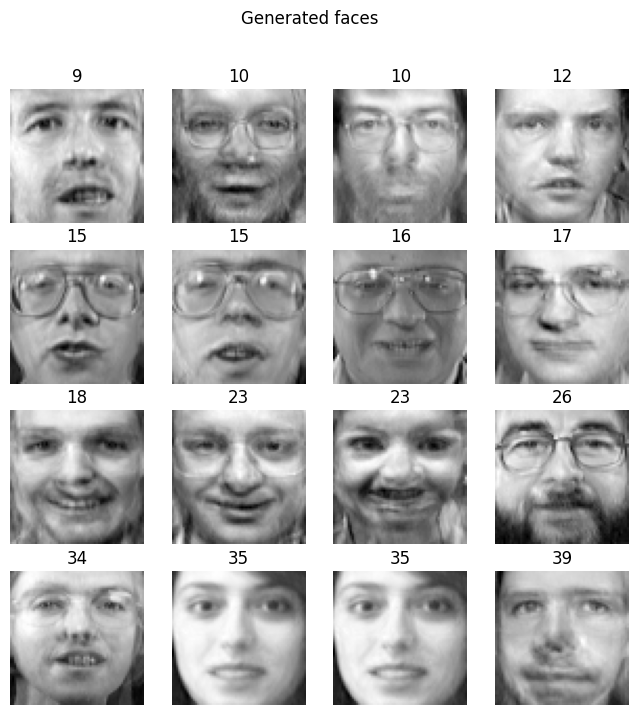

In [ ]:
# generating new samples
X_new, y_new = pca_gm[1].sample(16)
X_new = pca_gm[0].inverse_transform(X_new)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Generated faces")
plot_faces(X_new, y_new, fig, ncols=4)

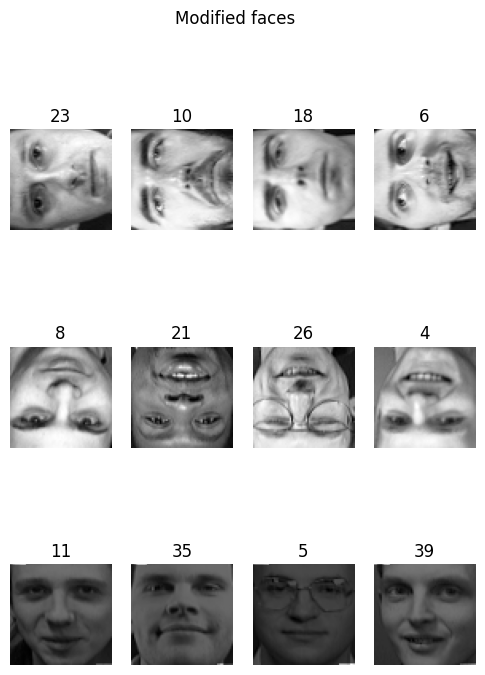

In [ ]:
# modifying some images
N = 4

X_rot = X_train[:N].copy().reshape((-1, 64, 64))
X_rot = np.rot90(X_rot, axes=(1, 2))
X_rot = X_rot.reshape((-1, 4096))

X_flip = X_train[N:2*N].copy().reshape((-1, 64, 64))
X_flip = X_flip[:, ::-1]
X_flip = X_flip.reshape((-1, 4096))

X_darken = X_train[2*N:3*N].copy()
X_darken[:, 10:-10] *= 0.4

X_bad = np.vstack((X_rot, X_flip, X_darken))
y_bad = y_train[:3*N]

fig = plt.figure(figsize=(6,8))
fig.suptitle("Modified faces")
plot_faces(X_bad, y_bad, fig, ncols=4)

In [ ]:
# comparing the (mean) log likelihoods of the original images and the modified images
print("original mean log likelihood:", pca_gm[1].score(pca_gm[0].transform(X_train[:3*N])))
print("modified mean log likelihood:", pca_gm[1].score(pca_gm[0].transform(X_bad)))

original mean log likelihood: 1141.4604149050228
modified mean log likelihood: -43594108.599537075


## Subexercise 4: PCA for anomaly detection

In [ ]:
pca = PCA(n_components=0.99)
pca.fit(X_train)
X_sample = X_train[:3*N]
X_sample_pca = pca.transform(X_sample)
X_sample_recovered = pca.inverse_transform(X_sample_pca)
print("mean reconstruction error of inliers:", np.mean((X_sample - X_sample_recovered) ** 2))

mean reconstruction error of inliers: 0.0001833181


In [ ]:
X_bad_recovered = pca.inverse_transform(pca.transform(X_bad))
print("mean reconstruction error of outliers", np.mean((X_bad - X_bad_recovered) ** 2))

mean reconstruction error of outliers 0.005460115


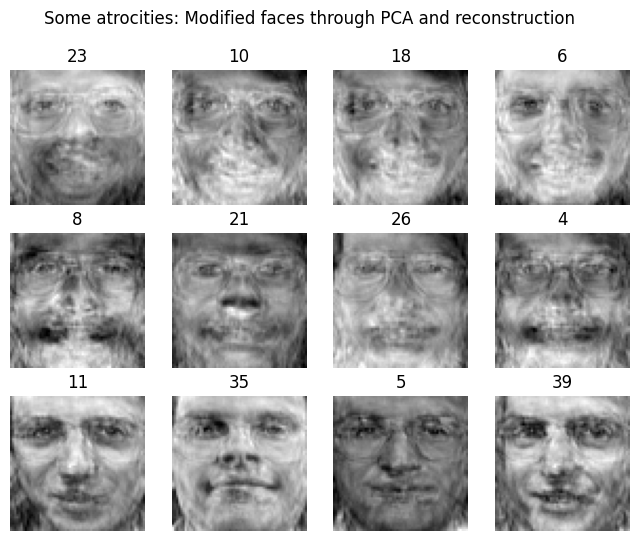

In [ ]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle("Some atrocities: Modified faces through PCA and reconstruction")
plot_faces(X_bad_recovered, y_bad, fig, ncols=4)